<a href="https://colab.research.google.com/github/anubhav48/Catboost-vs-Lightboost-vs-XGBoost-vs-Snapboost/blob/master/Cyclops_ImgData_BoostingAlgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Performance of Gradient Boosting Algorithms on a Image Dataset**

# This Notebook contains the comparative analysis of 3 Boosting Algorithms -
XGBoost, SnapBoost and LightGBM trained and tested on a Image Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sys
import os
import warnings
from datetime import datetime
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import pickle
import lightgbm as lgb
from xgboost import XGBClassifier
from pai4sk import BoostingMachine
from matplotlib import pyplot as plt

# **Loading the data**

In [2]:
#
# TAKEN FROM https://keras.io/examples/cifar10_cnn/
# but with load_data() pulled out to work with your own cifar data set
#

def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_data():
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = 'cifar-10-batches-py'

    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1,1):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))

#     if K.image_data_format() == 'channels_last':
#         x_train_local = x_train_local.transpose(0, 2, 3, 1)
#         x_test_local = x_test_local.transpose(0, 2, 3, 1)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)


batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [3]:
# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = load_data()

# **Preprocess the data**

In [4]:
 # X_train is 50000 rows of 3x32x32 values --> reshaped in 50000 x 3072
RESHAPED = 3072

X_train = X_train.reshape(50000, RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
  # normalize the datasets
X_train /= 255.
X_test /= 255.

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [6]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, pred, average="macro"):
    lb = preprocessing.LabelBinarizer() 
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    pred = lb.transform(pred)
    return roc_auc_score(y_test, pred, average=average)

# **Fit SnapBoost model to the data**

In [7]:
 max_depth = 6
num_round = 100
learning_rate = 0.1
use_gpu = False
num_threads = 16
booster = BoostingMachine(objective='logloss', num_round=num_round, min_max_depth=max_depth, max_max_depth=max_depth,
                             learning_rate=learning_rate, random_state=42, use_gpu=use_gpu, n_threads=num_threads)
t1=datetime.now()
booster.fit(X_train,y_train)
t2=datetime.now()
execution_time_snap_boost = t2-t1
t3 = datetime.now()
ypred = booster.predict(X_test)
t4 = datetime.now()
accuracy_snap_boost = round(multiclass_roc_auc_score(y_test,ypred.round()),2)
print("Accuracy score = ",accuracy_snap_boost*100,"%")
print("Execution time = ",execution_time_snap_boost)
print("Prediction time = ",t4-t3)
snap_boost_train_time = t2-t1

Accuracy score =  50.0 %
Execution time =  0:00:08.629729
Prediction time =  0:00:00.022640


# **Fit LightGBM model to the data**

In [8]:
params = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
params['metric'] = ['auc', 'binary_logloss']

train_data=lgb.Dataset(X_train,label=y_train)

num_round=50
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3 = datetime.now()
ypred2=lgbm.predict(X_test)
t4 = datetime.now()

for i in range(0,len(ypred2)): 
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0
accuracy_lgbm = round(accuracy_score(ypred2,y_test),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  10.0 %
Execution time =  0:00:00.360208
Prediction time =  0:00:00.021002


# **Fit XGBoost model to the data**

In [8]:
from xgboost import XGBClassifier
model = XGBClassifier()
t1=datetime.now()
model.fit(X_train,y_train)
t2=datetime.now()
execution_time_xgb = t2-t1
t3 = datetime.now()
y_pred = model.predict(X_test)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(accuracy_score(y_pred,y_test),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)
xgb_train_time = t2-t1

Accuracy score =  28.82 %
Execution time =  0:00:35.267812
Prediction time =  0:00:3.812345


# **Results and Plots**



# **1.Accuracy Plot**

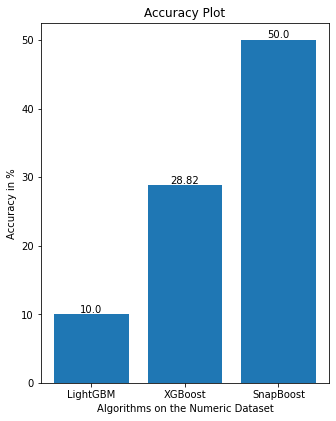

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (4,5))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_snap_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

# **2.Training Time Plot**

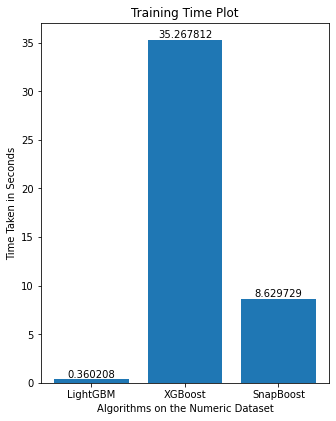

In [12]:
lg = float(str(lgbm_train_time)[5:])
sb = float(str(snap_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (4,5))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','SnapBoost']
training_time = [lg,xgb,sb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Numeric Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()